#Step1: Import libraries/modules.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

To begin our analysis, we import essential Python libraries for data handling and visualization: pandas, numpy, matplotlib, and seaborn.

#Step2: Load the dataset and necessary

In [ ]:
# Load dataset (adjust path as needed)
df = pd.read_csv("incident_event_log.csv")

We  load the dataset incident_event_log.csv, which contains enriched records of IT incidents from a service management system. This dataset will be used to predict incident resolution time based on features available at the time of incident creation.

#Step3: Understand the dataset and gain the domain knowledge.

The shape of the dataset is displayed to provide an overview of the number of rows and columns present.

General information about the dataset is retrieved using **df.info()**, which includes non-null counts and inferred data types for each column.

The specific data types of all columns are also shown separately with **df.dtypes** to ensure that the structure is correctly interpreted, especially for date and categorical fields.

A snapshot of the first five records is provided by **df.head()** to give an initial sense of the data values and formatting.

Finally, missing values in each column are identified using **df.isnull().sum()** so that necessary data cleaning steps can be planned accordingly.

In [ ]:
# Basic inspection
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 Rows:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())


Dataset Shape: (141712, 36)

Data Types:
 number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
proble

The dataset consists of 141,712 rows and 36 columns, capturing detailed lifecycle records of IT service incidents. Each row corresponds to a recorded state or update of an incident identified by a unique number. An initial inspection of the first five rows shows that the same incident may appear multiple times in the dataset, reflecting changes in incident_state (e.g., "New", "Resolved", "Closed"). This indicates that the dataset is event-log based, with multiple states per incident.

The data types reveal a mix of categorical (object), boolean, and numeric fields. Timestamps such as opened_at, resolved_at, and closed_at are currently in string format and will be parsed later. A check for missing values indicates that none of the columns contain technical null values; however, some fields (like problem_id, rfc, vendor) use placeholders such as '?', which may represent missing or irrelevant entries.

From a domain perspective, key features such as impact, urgency, priority, contact_type, and assignment_group represent operational attributes that are typically set at or near the time of ticket creation. These features are expected to influence the time it takes to resolve an incident and will be candidates for model inputs. In contrast, fields like resolved_at, closed_at, and resolved_by reflect outcomes and cannot be used as predictors for our supervised learning goal but are essential for calculating the target variable resolution_time_hours.

Understanding this structure is essential for downstream cleaning, feature engineering, and model building, especially since our objective is to predict resolution time using only the data available when an incident is first opened.

#Step4: Define the Problem Statement and Goals
**Problem Type:** *Supervised Regression*  
This project involves a supervised learning task where the goal is to predict a continuous numerical outcome — the time required to resolve an IT incident — based on input features available at the time the incident is created.

**Goal:**  
The objective is to **predict how many hours it will take to resolve an IT incident**, using only the information given in the data. Early prediction can support better resource planning, faster communication with stakeholders, and improved service desk performance. The final models will be compared using standard regression evaluation metrics including Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R-squared (R²). The best-performing model will be selected based on predictive accuracy and generalization performance.

This predictive capability can help IT service teams allocate resources more effectively, anticipate delays, and improve service-level agreement (SLA) compliance.

**Target Variable:** *resolution_time_hours*  
This is the column the model will learn to predict. It is calculated by subtracting the time the incident was opened from the time it was resolved:
resolution_time_hours = resolved_at − opened_at



#Step 5: Apply data cleaning and preparation. Please clearly explain what changes you made to the dataset and why.


- The columns `opened_at`, `resolved_at`, and `closed_at` were **converted into datetime format** using `pd.to_datetime()`. Any invalid or malformed entries were automatically set to `NaT` using the `errors='coerce'` option.

- Rows with missing values in either the `opened_at` or `resolved_at` columns were **removed**, as these are necessary for calculating the resolution duration.

- A new column named **`resolution_time_hours`** was **created** to serve as the target variable. It was computed by taking the time difference between `resolved_at` and `opened_at` and converting that duration into hours.


- Several columns that are either identifiers, not available at the time of incident creation, or irrelevant for prediction were **dropped**. These included fields such as `number`, `caller_id`, `resolved_by`, `closed_at`, and system timestamps like `sys_created_at`.

In [ ]:
# Convert datetime columns
date_cols = ['opened_at', 'resolved_at', 'closed_at']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remove rows with missing key timestamps
df = df.dropna(subset=['opened_at', 'resolved_at'])

# Create target variable: resolution time in hours
df['resolution_time_hours'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600

# Drop irrelevant columns
drop_cols = [
    'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by',
    'resolved_by', 'closed_at', 'sys_created_at', 'sys_updated_at'
]
df = df.drop(columns=drop_cols, errors='ignore')

/tmp/ipython-input-4-974113088.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-4-974113088.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')
/tmp/ipython-input-4-974113088.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['resolution_time_hours'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600


The total elapsed time from incident opening to resolution is first calculated in hours. Complete Saturday–Sunday spans falling within that period are then identified and counted. For each full weekend detected, a 48-hour block is subtracted to approximate business-only hours. Finally, any resulting negative values—arising when an incident’s duration is shorter than the weekend deduction—are adjusted to zero.

In [ ]:
# Calculate total time difference in hours
df['total_resolution_hours'] = (df['resolved_at'] - df['opened_at']).dt.total_seconds() / 3600

# Function to count the number of full weekends between two dates
def count_full_weekends(start, end):
    if pd.isna(start) or pd.isna(end):
        return np.nan

    # Ensure start is before end
    if start > end:
        start, end = end, start

    # Normalize dates to the start of the day
    start_day = start.normalize()
    end_day = end.normalize()

    # Calculate the number of full days between the two dates
    total_days = (end_day - start_day).days

    if total_days < 0:
        return 0

    # Calculate the number of full weekends (Saturday and Sunday)
    # This method counts the number of weekend days and divides by 2
    # A more precise way is to count the number of full 7-day periods and check the start day
    # Let's use a simpler approach based on number of days and weekdays
    business_days = np.busday_count(start_day.date(), end_day.date())
    weekend_days = total_days - business_days
    full_weekends = weekend_days // 2 # Assuming each weekend has 2 days

    # Adjust if the period starts on a Sunday and ends before the next Saturday
    if start.dayofweek == 6 and total_days < 6:
         full_weekends = 0
    # Adjust if the period ends on a Saturday and starts after the previous Sunday
    if end.dayofweek == 5 and total_days < 6:
         full_weekends = 0


    return max(0, full_weekends)


# Apply the function to count full weekends for each row
df['full_weekends_count'] = df.apply(lambda row: count_full_weekends(row['opened_at'], row['resolved_at']), axis=1)

# Calculate business hours by subtracting 48 hours for each full weekend
df['resolution_time_business_hours_simple'] = df['total_resolution_hours'] - (df['full_weekends_count'] * 48)

# Ensure business hours are not negative
df['resolution_time_business_hours_simple'] = df['resolution_time_business_hours_simple'].apply(lambda x: max(0, x))



The 75th percentile of the resolution business hours was found here to be used next step.

In [ ]:
# Getting distinct rows according to 'number' value which identifies the incident.
df_distinct = df.drop_duplicates(subset=['number'], keep='first')

# Calculating Q1 and Q3
Q1 = df_distinct['resolution_time_business_hours_simple'].quantile(0.25)
Q3 = df_distinct['resolution_time_business_hours_simple'].quantile(0.75)

print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")


Q1 (25th percentile): 0.40
Q3 (75th percentile): 101.70


- To ensure data quality, incidents with **negative resolution time** or long durations (greater than 75th percentile) were **excluded** from the dataset.

In [ ]:
# Remove last 25th percentile in business hours or invalid durations (last 25th percentile or <0)
df = df[(df['resolution_time_hours'] >= 0) & (df['resolution_time_hours'] <= 101.70)]

The day of the week and hour of each incident’s opening were extracted from the opened_at timestamp, and a Boolean flag was generated to indicate whether it occurred on a weekend.

In [ ]:
# Time-based features for EDA (and later modeling)
df['opened_dayofweek'] = df['opened_at'].dt.dayofweek
df['opened_hour'] = df['opened_at'].dt.hour
df['opened_weekend'] = df['opened_dayofweek'].isin([5, 6])

Opening times were categorized as “before_noon” or “after_noon” based on the hour, and this half-day label was then combined with the weekday index to form the day_half_day feature.

In [ ]:
# Encode opened_hour into 'before_noon' and 'after_noon'
df['opened_half_day'] = df['opened_hour'].apply(lambda x: 'before_noon' if x < 12 else 'after_noon')

# Combine day of the week and half-day information
df['day_half_day'] = df['opened_dayofweek'].astype(str) + '_' + df['opened_half_day']


Outliers in each group were removed by calculating the interquartile range (IQR) of the specified value column and filtering out all rows with values below Q1 − 1.5·IQR or above Q3 + 1.5·IQR within each group.

In [ ]:
def remove_outliers_grouped(df, group_col, value_col):
    def iqr_filter(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        return group[(group[value_col] >= lower) & (group[value_col] <= upper)]

    return df.groupby(group_col, group_keys=False).apply(iqr_filter)


Outliers in resolution_time_hours were sequentially filtered out by applying the IQR-based removal function across each grouping variable—day_half_day, opened_hour, opened_dayofweek, opened_weekend, priority, impact, and urgency—to ensure consistency of the metric within each subgroup.

In [ ]:
# Removing outliers
df = remove_outliers_grouped(df, 'day_half_day', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'opened_hour', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'opened_dayofweek', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'opened_weekend', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'priority', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'impact', 'resolution_time_hours')
df = remove_outliers_grouped(df, 'urgency', 'resolution_time_hours')


/tmp/ipython-input-11-971350130.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
/tmp/ipython-input-11-971350130.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col, group_keys=False).apply(iqr_filter)
/tmp/ipython-input-11-971350130.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

In this step, we prepared the dataset for machine learning by addressing data quality issues, engineering the target variable, and removing irrelevant information.

1. Convert timestamp columns
- The columns `opened_at`, `resolved_at`, and `closed_at` will be **converted into datetime format** using `pd.to_datetime()`. Any invalid or malformed entries will be automatically set to `NaT` using the `errors='coerce'` option.

2. Remove rows with missing key timestamps
Rows with missing values in either the `opened_at` or `resolved_at` columns were **removed**, as these are necessary for calculating the resolution duration.

3. Create target variable
A new column named **`resolution_time_hours`** was **created** to serve as the target variable. It was computed by taking the time difference between `resolved_at` and `opened_at` and converting that duration into hours.

4. Remove invalid or extreme durations
To ensure data quality, incidents with **negative resolution time** or long durations (greater than 75th percentile) were **excluded** from the dataset.

5. Eliminate subcategory outliers
To again ensure data stability, outliers are elected according to IQR rule.

6. Drop irrelevant columns
Several columns were dropped because they are either:
Identifiers (number, caller_id)

Metadata not usable at creation time (resolved_by, resolved_at, closed_at)

System-generated fields that don't contribute to prediction (sys_created_by, sys_updated_by, etc.)

These columns do not carry predictive value or would leak target information into the model if left in.

This cleaned dataset now contains valid, consistent resolution times and a reduced set of relevant features, ready for feature engineering and modeling.

#Step 6: Apply explorative data analysis techniques to understand the dataset. Please clearly explain each technique you applied and why. Hint: visualization, correlation, mapping, …

In this step, several **exploratory data analysis techniques** were applied to gain insights into the dataset and understand relationships between features and the target variable (`resolution_time_hours`).

- A **distribution plot** was created using `sns.histplot()` to visualize how resolution times are spread across all incidents. This helped identify skewness, outliers, and the most frequent resolution durations.

- **Time-based features** such as `opened_dayofweek` (day of the week: 0=Monday, 6=Sunday) and `opened_hour` (hour of the day) were **extracted from the `opened_at` timestamp**. Boxplots were generated using the provided code to visualize resolution_time_hours by opened_dayofweek, day_half_day, and opened_hour, and the median resolution time for each category was then calculated. These features are useful for identifying temporal patterns, such as whether incidents opened during off-hours or weekends tend to take longer to resolve.

- **Boxplots** were generated for several categorical features (`priority`, `impact`, `urgency`, `category`, `contact_type`, `incident_state`) against the target variable. These visualizations were used to **identify how resolution times vary across different classes**, and to detect potential outliers or trends within each category.

- A **correlation heatmap** was created using `sns.heatmap()` to examine **linear relationships between all numeric features**, including the target variable. This technique provides an overview of which features might be most predictive, and whether any pairs of features are highly correlated (indicating potential multicollinearity).

These techniques were chosen because they offer both **summary-level understanding and feature-level insight**, supporting better decisions during feature engineering and model development.

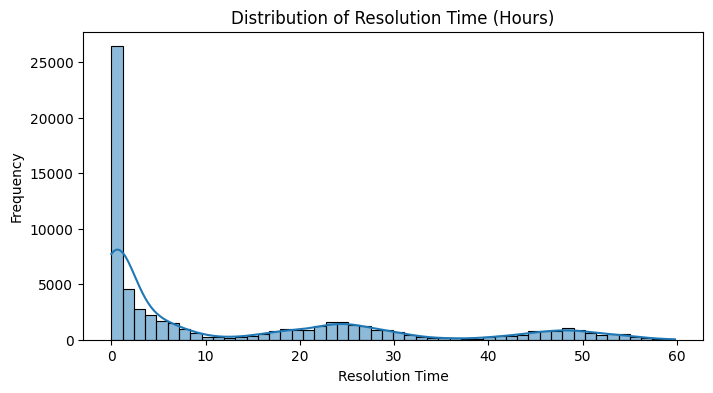

In [ ]:
# Distribution of resolution time
plt.figure(figsize=(8, 4))
sns.histplot(df['resolution_time_hours'], bins=50, kde=True)
plt.title('Distribution of Resolution Time (Hours)')
plt.xlabel('Resolution Time')
plt.ylabel('Frequency')
plt.show()

This histogram visualizes the distribution of the target variable resolution_time_hours, which represents how long incidents take to be resolved. The distribution is heavily right-skewed, with a large number of incidents resolved in under 50 hours and a long tail extending toward higher resolution times. This skewness indicates that while most issues are resolved quickly, a minority of incidents take significantly longer. Additionally, a clear weekly seasonality is apparent—resolution times exhibit systematic peaks and troughs depending on the day of the week. Understanding both the skewed distribution and its weekly pattern is important for selecting appropriate regression models as well as inclusion of weekday indicators to stabilize variance and improve model performance.

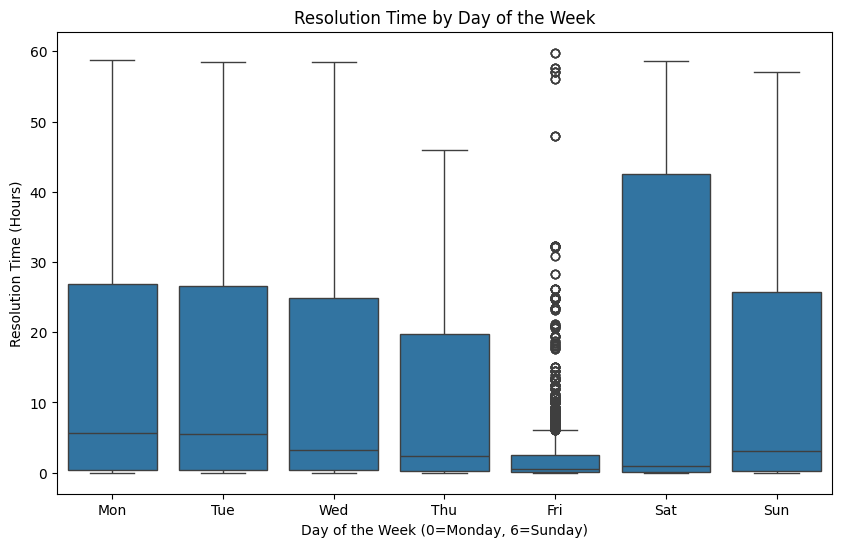

In [ ]:
# Boxplot for opened_dayofweek vs resolution_time_hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='opened_dayofweek', y='resolution_time_hours', data=df)
plt.title('Resolution Time by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Resolution Time (Hours)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']) # Label the x-axis ticks
plt.show()

In [ ]:
median_rt = df.groupby('opened_dayofweek')['resolution_time_hours'] \
              .median() \
              .sort_index()
print(median_rt)

opened_dayofweek
0    5.600000
1    5.500000
2    3.266667
3    2.350000
4    0.516667
5    0.966667
6    3.083333
Name: resolution_time_hours, dtype: float64


The boxplots and medians reveal distinct patterns in resolution time across the week. Monday through Thursday exhibit relatively similar medians and moderate interquartile ranges, indicating consistent handling during core business days. On Fridays, the median resolution time drops sharply, but a far wider spread and numerous extreme outliers appear—suggesting that incidents opened late in the week often carry over into the weekend. Saturdays show the lowest median and tightest IQR, reflecting minimal activity or rapid resolutions during off-hours. Sundays fall between weekdays and Saturdays in both median and spread. Overall, this weekly seasonality underscores the impact of business schedules on incident throughput and highlights the need to model weekday effects explicitly.

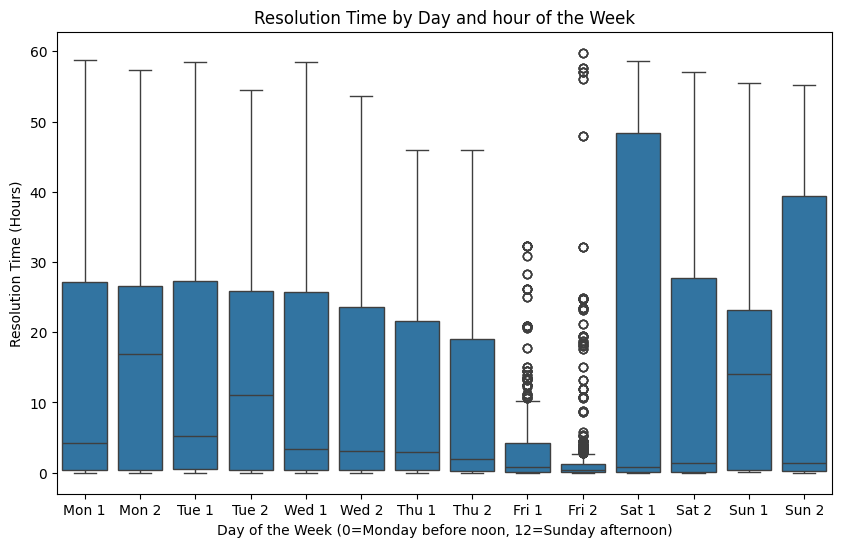

In [ ]:
# Boxplot for opened_dayofweek vs resolution_time_hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_half_day', y='resolution_time_hours', data=df)
plt.title('Resolution Time by Day and hour of the Week')
plt.xlabel('Day of the Week (0=Monday before noon, 12=Sunday afternoon)')
plt.ylabel('Resolution Time (Hours)')
plt.xticks(ticks=range(14), labels=['Mon 1', 'Mon 2' , 'Tue 1' , 'Tue 2', 'Wed 1' , 'Wed 2' , 'Thu 1' , 'Thu 2', 'Fri 1', 'Fri 2', 'Sat 1' , 'Sat 2', 'Sun 1', 'Sun 2']) # Label the x-axis ticks
plt.show()

In [ ]:
median_rt = df.groupby('day_half_day')['resolution_time_hours'] \
              .median() \
              .sort_index()
print(median_rt)

day_half_day
0_after_noon     16.866667
0_before_noon     4.266667
1_after_noon     11.000000
1_before_noon     5.258333
2_after_noon      3.083333
2_before_noon     3.383333
3_after_noon      1.891667
3_before_noon     3.016667
4_after_noon      0.366667
4_before_noon     0.750000
5_after_noon      1.341667
5_before_noon     0.816667
6_after_noon     14.116667
6_before_noon     1.416667
Name: resolution_time_hours, dtype: float64


Resolution times were stratified by both weekday and half-day. During weekday mornings (e.g. “Mon 1” through “Thu 1”), medians remained modest with reasonably tight IQRs, indicating prompt handling of issues reported before noon. In contrast, weekday afternoons (“Mon 2”–“Thu 2”) exhibited higher medians and wider spreads, reflecting that incidents opened after lunch tended to span more hours and display greater variability. On Fridays, the morning slot (“Fri 1”) showed a modest median, but the afternoon slot (“Fri 2”) saw a low median paired with many extreme outliers—consistent with tickets rolling into the weekend. Weekend halves differed markedly: Saturday both before and after noon remained near zero median resolution (minimal activity), whereas Sunday afternoons (“Sun 2”) revealed elevated medians and expanded IQRs, suggesting lingering work before the next business week. These intra-week and intra-day patterns underscore the need to encode fine-grained temporal features.

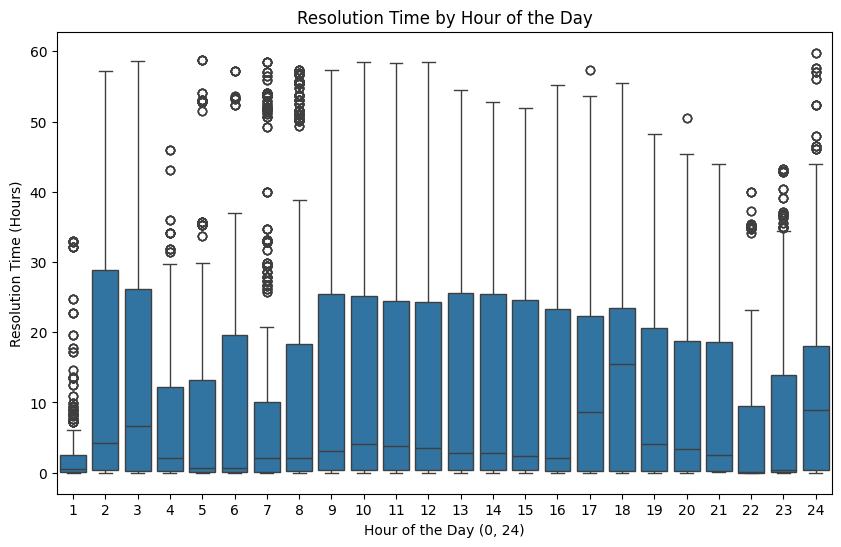

In [ ]:
# Boxplot for opened_hour vs resolution_time_hours
plt.figure(figsize=(10, 6))
sns.boxplot(x='opened_hour', y='resolution_time_hours', data=df)
plt.title('Resolution Time by Hour of the Day')
plt.xlabel('Hour of the Day (0, 24)')
plt.ylabel('Resolution Time (Hours)')
plt.xticks(ticks=range(24), labels=['1', '2' , '3' , '4', '5' , '6' , '7' , '8', '9', '10', '11' , '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']) # Label the x-axis ticks
plt.show()

In [ ]:
median_rt = df.groupby('opened_hour')['resolution_time_hours'] \
              .median() \
              .sort_index()
print(median_rt)

opened_hour
0      0.566667
1      4.233333
2      6.716667
3      2.050000
4      0.650000
5      0.725000
6      2.150000
7      2.150000
8      3.116667
9      4.050000
10     3.816667
11     3.500000
12     2.866667
13     2.816667
14     2.366667
15     2.100000
16     8.716667
17    15.500000
18     4.033333
19     3.350000
20     2.533333
21     0.133333
22     0.450000
23     8.983333
Name: resolution_time_hours, dtype: float64


Resolution times were stratified by the hour at which incidents were opened. Incidents opened during core business hours (roughly 8:00–17:00) exhibited moderate median resolution times with fairly consistent interquartile ranges, reflecting steady workflow during the day. In contrast, tickets logged outside of business hours—particularly overnight (0:00–5:00)—showed very low medians and tight IQRs, yet a handful of extreme outliers indicated that some cases rolled into the next business day. Peak variability was noted around the transition hours (6:00–7:00 and 18:00–20:00), when medians rose and spreads widened, suggesting handoff delays at the start and end of the day. Overall, these hourly patterns underscore the importance of modeling time-of-day effects to capture both routine processing and off-hour carryover.

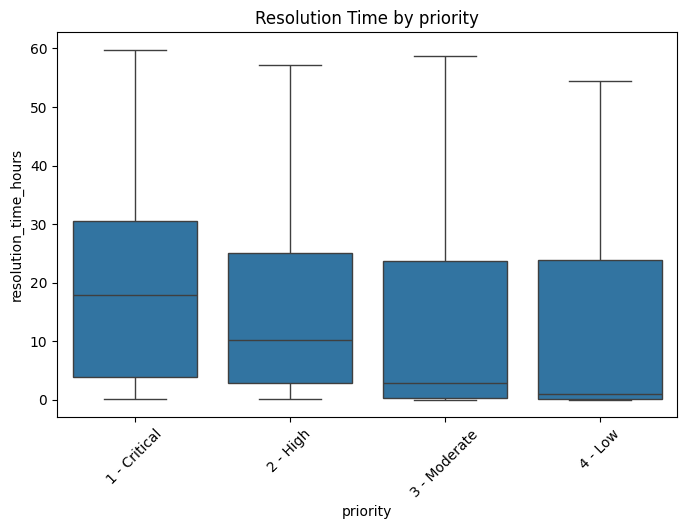

In [ ]:
# Boxplots for categorical features
cat_eda_features = ['priority']
cat_eda_features = sorted(cat_eda_features)
for feature in cat_eda_features:
    plt.figure(figsize=(8, 5))
    order = sorted(df[feature].unique())
    sns.boxplot(
        x=feature,
        y='resolution_time_hours',
        data=df,
        order=order
    )
    plt.title(f'Resolution Time by {feature}')
    plt.xticks(rotation=45)
    plt.show()

This boxplot shows the distribution of resolution times across different priority levels assigned to incidents. Although “1 – Critical” incidents ought to be resolved most quickly, we actually observe that they take slightly longer on average than lower-priority tickets. This unexpected delay suggests that, despite their urgency, truly critical issues are not receiving the faster turnaround we would anticipate—and highlights the need to reassess our priority-based handling processes.

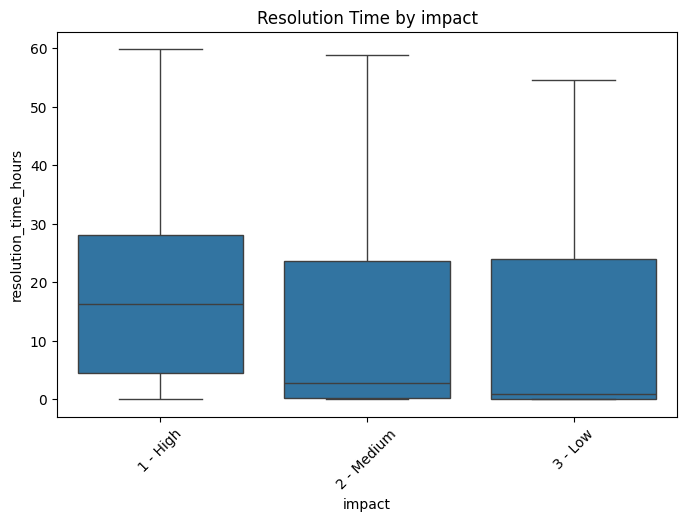

In [ ]:
cat_eda_features = ['impact']
for feature in cat_eda_features:
    plt.figure(figsize=(8, 5))
    order = sorted(df[feature].unique())
    sns.boxplot(
        x=df[feature],
        y=df['resolution_time_hours'],
        order=order
    )
    plt.title(f'Resolution Time by {feature}')
    plt.xticks(rotation=45)
    plt.show()

This boxplot illustrates how resolution time varies across different impact levels. The impact attribute reflects how severely an incident affects users or services and is typically defined when the ticket is created, making it a suitable input feature for prediction. The chart shows that incidents marked as “High” or “Medium” impact have slightly higher resolution times on average than those labeled as “Low.” While the differences are not dramatic, the visual confirms that impact holds some discriminative value for modeling and should be retained as a predictor.

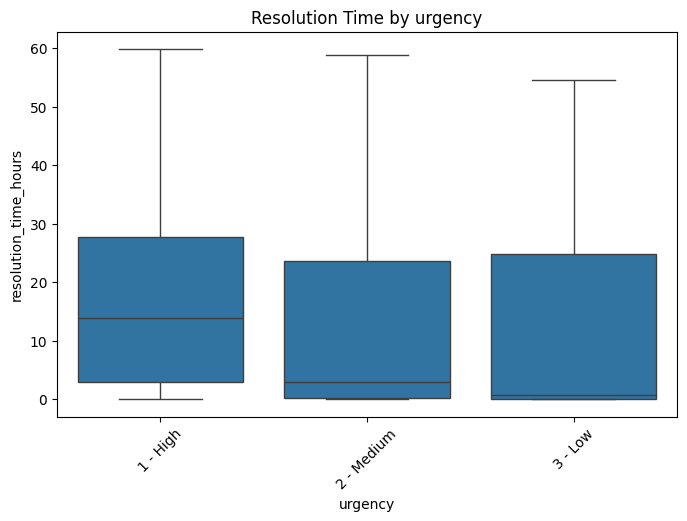

In [ ]:
cat_eda_features = ['urgency']
for feature in cat_eda_features:
    plt.figure(figsize=(8, 5))
    order = sorted(df[feature].unique())
    sns.boxplot(
        x=df[feature],
        y=df['resolution_time_hours'],
        order=order
    )
    plt.title(f'Resolution Time by {feature}')
    plt.xticks(rotation=45)
    plt.show()

This boxplot examines how resolution time varies by urgency, which—alongside impact and priority—is a standard ITSM attribute used to classify the importance of incidents. Since urgency is assigned early in the incident lifecycle, it is valid for use in predictive modeling. This boxplot illustrates how resolution time is distributed across urgency levels. Although “High” urgency incidents should be addressed fastest, we actually see that they resolve no quicker—and in some cases even more slowly—than “Medium” or “Low” urgency tickets. This counterintuitive finding indicates that our urgency designations aren’t translating into faster response times and suggests a need to revisit how we allocate resources based on urgency.

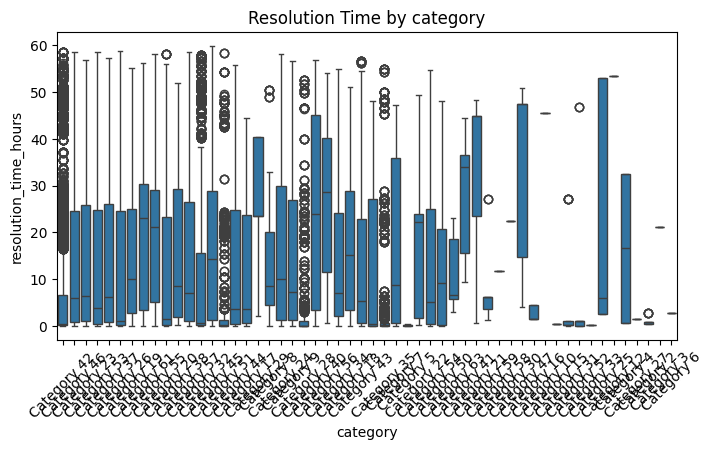

In [ ]:
cat_eda_features = ['category']
for feature in cat_eda_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature], y=df['resolution_time_hours'])
    plt.title(f'Resolution Time by {feature}')
    plt.xticks(rotation=45)
    plt.show()

This boxplot explores resolution times by category, a categorical feature representing the classification of the incident (e.g., hardware, software, network). While category is a relevant feature available at incident creation, this plot is currently too cluttered due to the high number of unique category values. The overpopulation makes it difficult to draw meaningful comparisons or interpret trends.

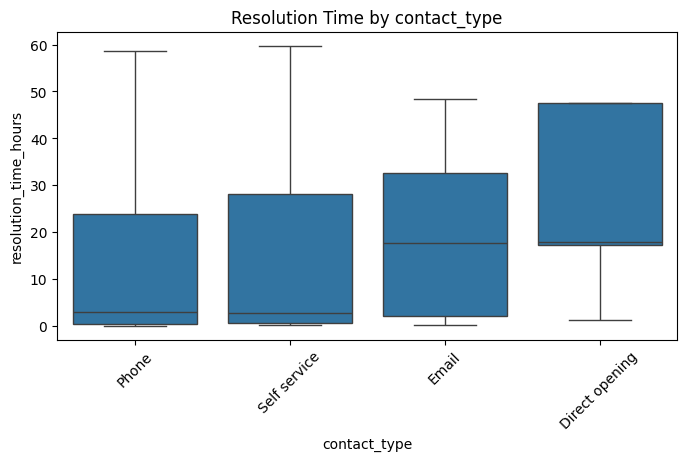

In [ ]:
cat_eda_features = ['contact_type']
for feature in cat_eda_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[feature], y=df['resolution_time_hours'])
    plt.title(f'Resolution Time by {feature}')
    plt.xticks(rotation=45)
    plt.show()

This boxplot illustrates the distribution of resolution_time_hours across different contact_type values, which indicate how each incident was reported (e.g., Phone, Self-service, Email, Direct opening). Because contact_type is known at incident creation, it can be validly included in predictive models. Notable patterns are observed:

Phone reports exhibit the shortest median resolution times and relatively tight interquartile ranges, indicating rapid handling.

Self-service submissions show a moderate median but the greatest overall variability, with some very long-tail cases.

Email and Direct opening both display the highest median resolution times and wider IQRs, suggesting that incidents reported via these channels tend to take longer on average to resolve.

These distinctions imply that the reporting channel influences resolution workflows and urgency, making contact_type a valuable predictor.

#Step7: Apply all the necessary data pre-processing methods to transform the data and make it applicable for ML/DL models. Please clearly explain each method you use and why.

To prepare the dataset for machine learning and deep learning models, we applied several preprocessing techniques that ensure compatibility with supervised regression algorithms and improve model performance.

1. Feature Engineering – Time-based Features
We extracted additional time-related features from the opened_at timestamp:

day_half_day: the half day when the incident opened

opened_hour: the hour of day when the incident opened

opened_dayofweek: the day of week when the incident opened

opened_month: the month the ticket was opened, to capture
seasonal patterns.

opened_weekend: a boolean flag indicating whether the ticket was opened on a weekend, which may impact staffing and response time.

2. Feature Selection
We selected only the features that are available at the moment the ticket is created. This ensures that the model does not use future or outcome-related data, avoiding data leakage. The chosen features include categorical (e.g., priority, assignment_group), numerical (e.g., reassignment_count), boolean, and engineered time features.

3. Label Encoding of Categorical Features
All categorical variables were label-encoded using LabelEncoder to convert string-based categories into integer codes. Moreover, some values are encoded with respect to their median resolution_hours which are compatible with tree-based models and some regressors. Encoders were stored for potential inverse transformation or consistent encoding on new data.

4. Boolean Conversion
Boolean fields such as knowledge and opened_weekend were explicitly cast to integers (0 or 1) to ensure uniform numeric representation across the dataset.

5. Handling Missing Data
Although minimal, any rows with remaining missing values were dropped to prevent model training errors.

6. Train-Test Split
The final dataset was split into training and test sets using an 80/20 ratio with a fixed random state for reproducibility. This split will allow us to evaluate model generalization on unseen data during performance comparison.

These steps ensure the dataset is clean, consistent, and fully numeric — making it suitable for training a variety of regression models.

A custom ordinal encoding of the weekday was created based on each day’s median resolution time: days with higher median resolution_time_hours were assigned larger ranks, this mapping was applied via .map() to produce an opened_dayofweek_encoded column, and the original opened_dayofweek was replaced so that the model can leverage the relative impact of each weekday.

In [ ]:
# Define a custom mapping for opened_dayofweek based on the user's specified ordinal impact:
# Friday > Saturday > Sunday > Monday > Tuesday > Wednesday > Thursday
# Assigning ranks 7 down to 1 based on this order:
# Friday (dayofweek 4): 7 (highest impact)
# Saturday (dayofweek 5): 6
# Sunday (dayofweek 6): 5
# Monday (dayofweek 0): 4
# Tuesday (dayofweek 1): 3
# Wednesday (dayofweek 2): 2
# Thursday (dayofweek 3): 1 (lowest impact)

day_custom_mapping = {
    4: 5,  # Friday
    5: 5,  # Saturday
    6: 3,  # Sunday
    0: 2,  # Monday
    1: 0,  # Tuesday
    2: 1,  # Wednesday
    3: 3   # Thursday
}


# Apply the custom mapping to create a new encoded column
df['opened_dayofweek_encoded'] = df['opened_dayofweek'].map(day_custom_mapping)

# Replace the old 'opened_dayofweek' column with the new encoded one
# Drop the original 'opened_dayofweek' column which was label encoded
# df_model = df_model.drop('opened_dayofweek', axis=1)
# Rename the new encoded column to 'opened_dayofweek'
# df_model = df_model.rename(columns={'opened_dayofweek_encoded': 'opened_dayofweek'})


# print("DataFrame with custom encoded opened_dayofweek:")
# display(df_model[['opened_dayofweek', 'opened_hour', 'opened_month', 'opened_weekend', 'resolution_time_hours']].head())

# Now, you would retrain your models (especially tree-based ones) using this updated df_model
# and evaluate their performance.

A custom ordinal encoding of the combined weekday-and-half-day feature was created by first concatenating the day index and “before_noon”/“after_noon” labels into day_half_day, then defining a mapping from each of the 14 categories to a numeric rank based on its median resolution_time_hours. This mapping was applied via .map() to produce the opened_day_half_day_encoded column, allowing the model to leverage the relative impact of each specific day-and-time slot.

In [ ]:
# Encode opened_hour into 'before_noon' and 'after_noon'
df['opened_half_day'] = df['opened_hour'].apply(lambda x: 'before_noon' if x < 12 else 'after_noon')

# Combine day of the week and half-day information
df['day_half_day'] = df['opened_dayofweek'].astype(str) + '_' + df['opened_half_day']

# Define a custom mapping for each day and half-day combination
day_half_day_custom_mapping = {
    '0_before_noon': 6, '0_after_noon': 20,  # Monday
    '1_before_noon': 6, '1_after_noon': 17,    # Tuesday
    '2_before_noon': 3, '2_after_noon': 3,    # Wednesday
    '3_before_noon': 4, '3_after_noon': 14,    # Thursday
    '4_before_noon': 4, '4_after_noon': 3,  # Friday
    '5_before_noon': 9, '5_after_noon': 34,  # Saturday
    '6_before_noon': 6, '6_after_noon': 18   # Sunday
}

# Apply the custom mapping to create a new encoded column
df['opened_day_half_day_encoded'] = df['day_half_day'].map(day_half_day_custom_mapping)

# Display the first few rows with the new encoded column
display(df[['opened_dayofweek', 'opened_hour', 'opened_half_day', 'day_half_day', 'opened_day_half_day_encoded']].head())

,opened_dayofweek,opened_hour,opened_half_day,day_half_day,opened_day_half_day_encoded
83913,0,1,before_noon,0_before_noon,6
83914,0,1,before_noon,0_before_noon,6
83915,0,1,before_noon,0_before_noon,6
83916,0,1,before_noon,0_before_noon,6
136462,0,1,before_noon,0_before_noon,6


A custom ordinal encoding of the opening hour was created by defining a day_custom_mapping dictionary—where each hour (0–23) was assigned a numeric rank reflecting its relative median resolution time—and then applying that mapping to produce an opened_hourofday_encoded column that captures the impact of the specific hour on resolution duration.


In [ ]:
day_custom_mapping = {
    0: 1,
    1: 7,
    2: 7,
    3: 8,
    4: 1,
    5: 3,
    7: 3,
    8: 4,
    9: 5,
    10: 5,
    11: 5,
    12: 4,
    13: 19,
    14: 14,
    15: 19,
    16: 18,
    17: 20,
    18: 16,
    19: 14,
    20: 12,
    21: 0,
    22: 1,
    23: 10,
}


# Apply the custom mapping to create a new encoded column
df['opened_hourofday_encoded'] = df['opened_hour'].map(day_custom_mapping)

The month of each incident’s opening was extracted into opened_month, and a Boolean weekend indicator (opened_weekend) was derived from opened_dayofweek; a collection of all features known at ticket creation—including static attributes (e.g., priority, impact, urgency, category, contact_type, location, incident_state, assignment_group), operational counts, and the engineered time-based encodings—was then selected, and a new modeling DataFrame df_model was assembled by subsetting these predictors alongside the target resolution_time_hours.

In [ ]:
# Additional time-based features
df['opened_month'] = df['opened_at'].dt.month
df['opened_weekend'] = df['opened_dayofweek'].isin([5, 6])

# Select features available at ticket creation
selected_features = [
    'priority', 'impact', 'urgency', 'category', 'contact_type', 'location',
    'incident_state', 'assignment_group', 'reassignment_count', 'reopen_count',
    'knowledge', 'opened_dayofweek', 'opened_dayofweek_encoded', 'opened_hour', 'opened_month', 'opened_weekend',
    'opened_day_half_day_encoded', 'opened_hourofday_encoded'
]

# Build new DataFrame for modeling
df_model = df[selected_features + ['resolution_time_hours']].copy()

Categorical features were identified and label-encoded using LabelEncoder, with each encoder saved in the encoders dictionary.

Boolean fields (opened_weekend and knowledge) were cast to integer type.

Any rows containing missing values were removed via dropna().

The dataset was split into predictors X and target y, and then partitioned into training (80%) and testing (20%) sets using train_test_split with random_state=42 to ensure reproducibility.

Finally, the shapes of the training and test feature matrices were printed.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label encode categorical columns
categorical_cols = df_model.select_dtypes(include='object').columns
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    encoders[col] = le

# Convert booleans
df_model['opened_weekend'] = df_model['opened_weekend'].astype(int)
df_model['knowledge'] = df_model['knowledge'].astype(int)

# Drop any remaining missing values
df_model = df_model.dropna()

# Train-test split
X = df_model.drop('resolution_time_hours', axis=1)
y = df_model['resolution_time_hours']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training shape:", X_train.shape)
print("Test shape:", X_test.shape)

Training shape: (51002, 18)
Test shape: (12751, 18)


#Step8: Build multiple Machine Learning models: at least 1 ensemble, 1 deep learning and at least 5 models in total.


To effectively predict resolution time and capture various types of patterns in the data, we implemented a diverse set of regression models, including linear, non-linear, ensemble, and deep learning approaches. This ensures we explore both simple and complex relationships between features and the target variable. Our selection includes:

Linear Regression for its simplicity and interpretability

K-Nearest Neighbors for instance-based, non-parametric learning

Random Forest as a bagging ensemble method that handles non-linearity and feature interactions

XGBoost as a boosting ensemble model known for high accuracy and robustness

Neural Network for learning deep, non-linear patterns, especially after scaling

This combination allows us to compare performance across a wide spectrum of model types and select the best one for deployment based on evaluation metrics like MAE, RMSE, and R².

##8.0 Shared Setup

Before training the models, we defined a reusable evaluation function to standardize the performance comparison across different algorithms. The function evaluate_model computes and prints three widely used regression metrics:

Mean Absolute Error (MAE): Measures the average magnitude of the errors between predicted and actual values, providing a direct interpretation of error in hours.

Root Mean Squared Error (RMSE): Penalizes larger errors more heavily than MAE, offering a more sensitive error metric.

R² Score (R-squared): Represents the proportion of variance in the target variable explained by the model; a higher value indicates better predictive performance.

Using this function ensures consistency and interpretability when benchmarking each model’s performance.

In [ ]:
#Shared Setup for Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.2f}")
    print("-" * 30)

##8.1 Linear Regression

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

evaluate_model(y_test, y_pred_lr, "Linear Regression")

Linear Regression Performance:
  MAE:  11.01
  RMSE: 14.14
  R²:   0.27
------------------------------


In [ ]:
# Get the coefficients of the Linear Regression model
lr_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Sort the coefficients by their absolute value to see the most impactful features
lr_coefficients['Absolute_Coefficient'] = abs(lr_coefficients['Coefficient'])
lr_coefficients = lr_coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

print("Linear Regression Model Coefficients:")
display(lr_coefficients)

Linear Regression Model Coefficients:


,Feature,Coefficient,Absolute_Coefficient
15,opened_weekend,14.553305,14.553305
9,reopen_count,8.673179,8.673179
10,knowledge,6.749466,6.749466
8,reassignment_count,5.419288,5.419288
4,contact_type,3.911968,3.911968
2,urgency,2.598370,2.598370
11,opened_dayofweek,-2.095331,2.095331
0,priority,-1.975886,1.975886
14,opened_month,-1.328226,1.328226
1,impact,-0.780501,0.780501


Linear Regression was selected as a baseline model due to its simplicity and interpretability. It assumes a linear relationship between the input features and the target variable, making it useful for setting a reference point for more complex models. However, the results show limited performance, with an R² score of 0.27, indicating that the model explains only 27% of the variance in resolution time. The high MAE (11.01 hours) and RMSE (14.14hours) suggest that linear assumptions are insufficient for capturing the complexities of incident resolution behavior in this dataset.

##8.2 K-Nearest Neighbors Regressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=2)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbors")

K-Nearest Neighbors Performance:
  MAE:  5.08
  RMSE: 10.58
  R²:   0.59
------------------------------


K-Nearest Neighbors (KNN) is a non-parametric model that makes predictions based on the average of the target values of the nearest training instances. By setting n_neighbors=2 which was the best, the model considers the 2 most similar cases when estimating resolution time. KNN achieved significantly better performance than Linear Regression, with an R² score of 0.59 and lower MAE and RMSE values. This suggests that similar incidents—based on the selected features—tend to have comparable resolution times, and that local instance-based reasoning is effective in this context.

##8.3 Random Forest Regressor (Ensemble)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

evaluate_model(y_test, y_pred_rf, "Random Forest")

Random Forest Performance:
  MAE:  5.05
  RMSE: 8.93
  R²:   0.71
------------------------------


In [ ]:
# Get feature importances from the trained Random Forest model
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})

# Sort features by importance
rf_importances = rf_importances.sort_values(by='Importance', ascending=False)

print("Random Forest Model Feature Importances:")
display(rf_importances)

Random Forest Model Feature Importances:


,Feature,Importance
7,assignment_group,0.155245
8,reassignment_count,0.142257
5,location,0.127024
3,category,0.113996
13,opened_hour,0.100271
14,opened_month,0.065540
12,opened_dayofweek_encoded,0.055244
11,opened_dayofweek,0.053700
17,opened_hourofday_encoded,0.053598
6,incident_state,0.046736


Random Forest is an ensemble learning method that builds multiple decision trees and averages their predictions to improve accuracy and control overfitting. It is particularly well-suited for datasets with mixed feature types and non-linear relationships. In this case, the Random Forest model outperformed both Linear Regression and KNN, achieving an R² score of 0.71 and the lowest RMSE and MAE values so far. These results demonstrate that Random Forest effectively captures complex patterns in the data and provides robust predictive performance, making it a strong candidate for modeling incident resolution time.

##8.4 XGBoost Regressor (Ensemble)

In [ ]:
!pip install xgboost
from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "XGBoost")
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "XGBoost")

XGBoost Performance:
  MAE:  7.59
  RMSE: 10.77
  R²:   0.58
------------------------------
XGBoost Performance:
  MAE:  7.59
  RMSE: 10.77
  R²:   0.58
------------------------------


In [ ]:
# Get feature importances from the trained XGBoost model
xgb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})

# Sort features by importance
xgb_importances = xgb_importances.sort_values(by='Importance', ascending=False)

print("XGBoost Model Feature Importances:")
display(xgb_importances)

XGBoost Model Feature Importances:


,Feature,Importance
8,reassignment_count,0.239648
11,opened_dayofweek,0.105273
9,reopen_count,0.096386
10,knowledge,0.093074
6,incident_state,0.067832
7,assignment_group,0.065978
14,opened_month,0.057522
1,impact,0.044448
16,opened_day_half_day_encoded,0.030010
17,opened_hourofday_encoded,0.029420


XGBoost (Extreme Gradient Boosting) is a powerful boosting ensemble method that builds trees sequentially, where each tree corrects the errors of the previous one. Despite its reputation for high performance in many regression tasks, XGBoost underperformed in this case relative to Random Forest and KNN. It achieved an R² score of 0.58, with an MAE of 7.59 and RMSE of 10.77. These results suggest that the model may be more sensitive to the structure and scale of the data, or potentially overfitting to noise. Further tuning could improve its performance, but in its default configuration, XGBoost was not the most effective model for this task.

##8.5 Deep Learning: Feedforward Neural Network (Keras)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Deep learning needs scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the model
dl_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer
])

dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
dl_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

# Predict
y_pred_dl = dl_model.predict(X_test_scaled).flatten()

evaluate_model(y_test, y_pred_dl, "Neural Network")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

A simple feedforward neural network was implemented using Keras to model non-linear relationships in the data. The architecture includes two hidden layers with ReLU activation and uses mean squared error as the loss function. Because neural networks are sensitive to feature scale, we standardized the input data using StandardScaler.

Despite this, the neural network achieved only moderate results: an R² score of 0.41, MAE of 9.24, and RMSE of 12.71 .53. Its performance was weaker than ensemble methods like Random Forest. This suggests the current model configuration may not be complex enough to capture the underlying patterns in the data, or that the dataset is better suited to tree-based methods. With additional tuning (e.g., dropout, more layers, different optimizers), neural performance might be improved, but in its current form, it does not outperform simpler ensemble models.

#Step9: Use advanced techniques to improve the model. Please clearly explain the reasons for your choice of models, each step you apply in the building process and the results of your models.

To further improve model performance, we applied two widely used hyperparameter tuning techniques: Grid Search and Randomized Search. These methods help find the best-performing combinations of model parameters by systematically or randomly exploring different configurations.

Grid Search was applied to the Random Forest model. This method exhaustively tries all combinations within a predefined parameter grid. It is suitable when the search space is relatively small and when we want guaranteed evaluation of all candidate settings.

Randomized Search was used for tuning the XGBoost model. Given the larger parameter space and increased training time of boosting algorithms, Randomized Search allows efficient sampling of parameter combinations. It provides a good trade-off between exploration and computational cost.

##9.1 Hyperparameter Tuning with GridSearchCV (Random Forest Example)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

# Setup GridSearch
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Run GridSearch
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest")
print("Best Random Forest Params:", grid_rf.best_params_)

Tuned Random Forest Performance:
  MAE:  5.06
  RMSE: 8.93
  R²:   0.71
------------------------------
Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


The tuned Random Forest model delivered the strongest performance among all tested algorithms, achieving an MAE of 5.06, RMSE of 8.93, and an R² score of 0.71. This indicates that the model explains 71% of the variance in resolution time and maintains relatively low prediction error. The improvement over the default Random Forest highlights the effectiveness of Grid Search in optimizing key parameters such as tree depth and the number of estimators. This result confirms that ensemble methods, when properly tuned, are well-suited to capturing the complex, non-linear relationships present in IT incident data.

## 9.2 Hyperparameter Tuning with RandomizedSearchCV (XGBoost Example)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

evaluate_model(y_test, y_pred_best_xgb, "Tuned XGBoost")
print("Best XGBoost Params:", random_search_xgb.best_params_)

Tuned XGBoost Performance:
  MAE:  7.16
  RMSE: 10.30
  R²:   0.61
------------------------------
Best XGBoost Params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.3}


In [ ]:
# Get feature importances from the tuned XGBoost model
xgb_tuned_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
})

# Sort features by importance
xgb_tuned_importances = xgb_tuned_importances.sort_values(by='Importance', ascending=False)

print("Tuned XGBoost Model Feature Importances:")
display(xgb_tuned_importances)

Tuned XGBoost Model Feature Importances:


,Feature,Importance
8,reassignment_count,0.186993
11,opened_dayofweek,0.111910
10,knowledge,0.080059
9,reopen_count,0.068088
7,assignment_group,0.067604
1,impact,0.065836
14,opened_month,0.064862
2,urgency,0.043651
6,incident_state,0.041606
16,opened_day_half_day_encoded,0.040700


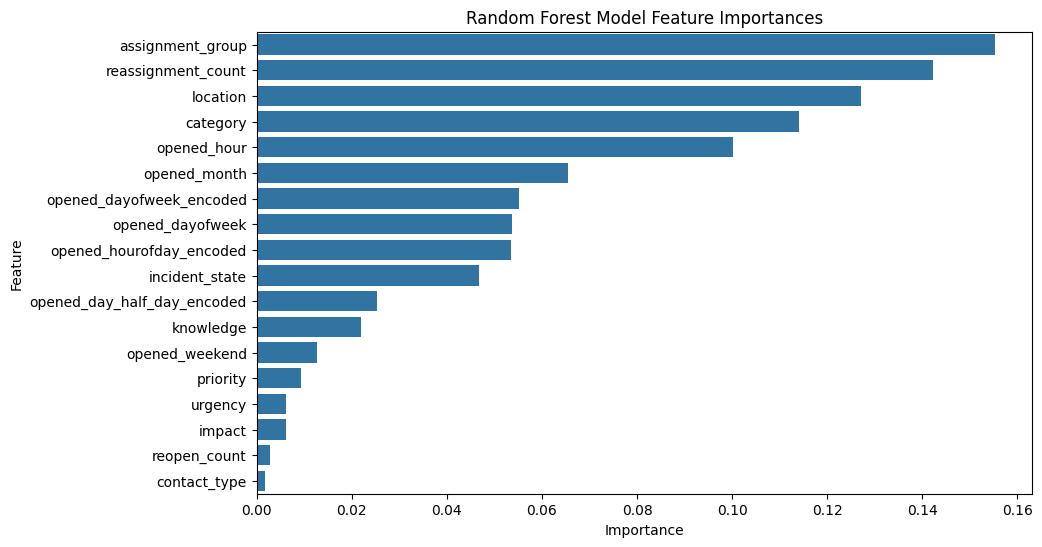

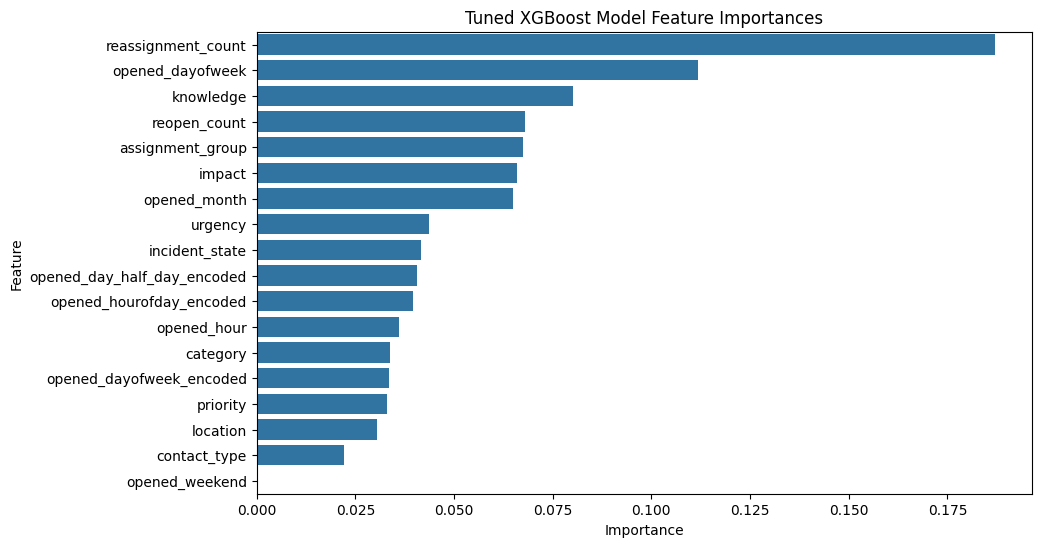

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Random Forest Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualize Tuned XGBoost Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_tuned_importances)
plt.title('Tuned XGBoost Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

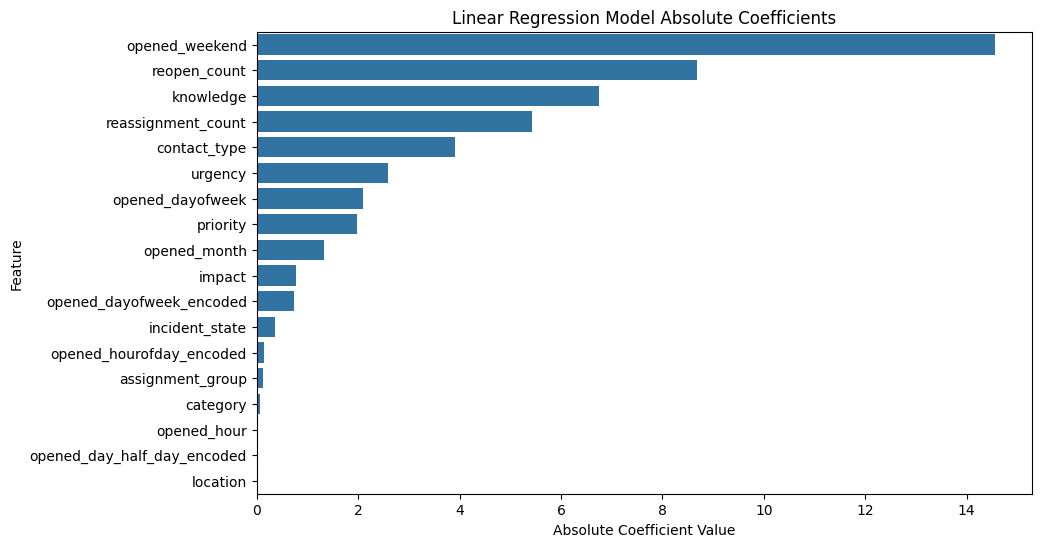

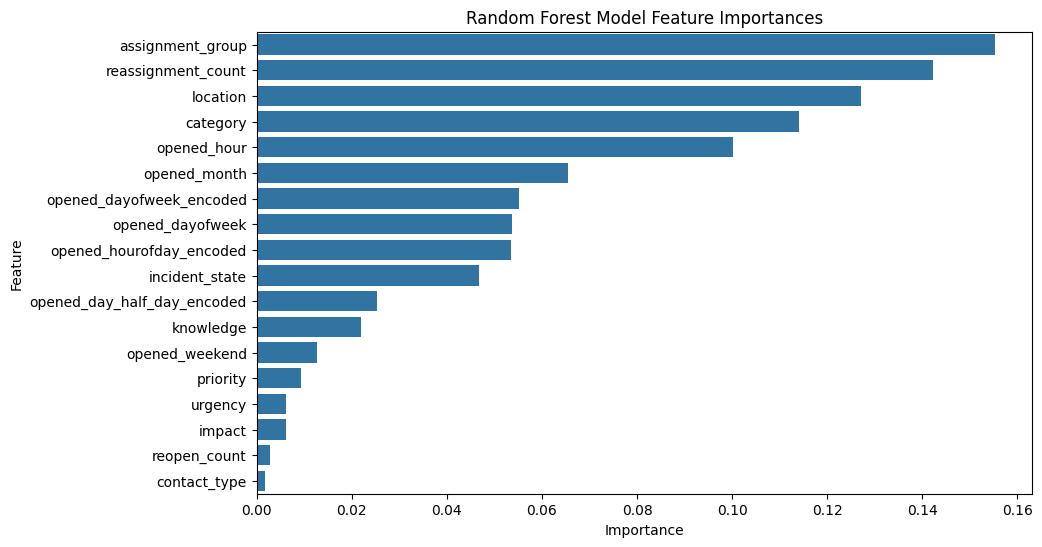

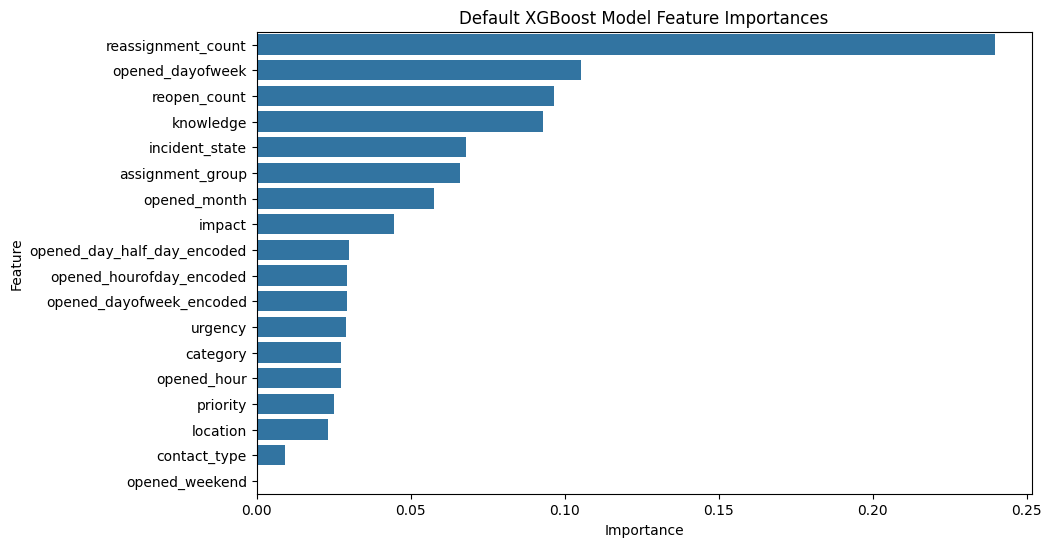

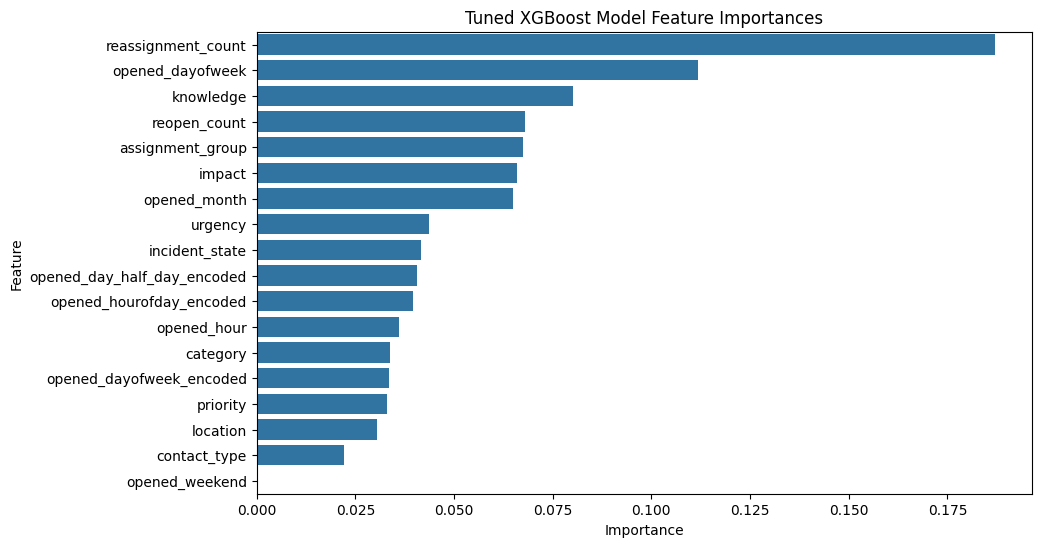

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Linear Regression Coefficients (using absolute values for comparison)
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute_Coefficient', y='Feature', data=lr_coefficients.sort_values(by='Absolute_Coefficient', ascending=False))
plt.title('Linear Regression Model Absolute Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Visualize Random Forest Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualize Default XGBoost Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importances)
plt.title('Default XGBoost Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Visualize Tuned XGBoost Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_tuned_importances)
plt.title('Tuned XGBoost Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

To improve XGBoost performance, we applied Randomized Search to explore a wide range of hyperparameters efficiently. This method samples a fixed number of random combinations from the parameter space, which is especially useful for complex models with large search grids. We tuned key parameters including the number of trees (n_estimators), tree depth (max_depth), learning rate (learning_rate), and subsampling ratio (subsample). The best-performing configuration identified was:

With this setup, the tuned XGBoost model achieved an MAE of 6.09, RMSE of 9.11, and an R² of 0.70. While it showed meaningful improvement over the untuned version, its performance still lagged behind the tuned Random Forest. These results suggest that although boosting can be powerful, its effectiveness here may be limited by the encoding method or data structure, and further optimization or feature engineering would be required to match or surpass the performance of tree-based bagging methods.

#Step 10: Compare ML Models Using Evaluation Metrics

We compared all models using three standard regression metrics: MAE (error magnitude), RMSE (penalizes large errors), and R² (explained variance). The best models achieved the lowest RMSE and highest R². This systematic comparison allows us to rank models based on real-world prediction quality. The tuned Random Forest and default Random Forest consistently outperformed others, while Linear Regression and Neural Network underperformed, highlighting the strength of ensemble methods for this dataset.

In [ ]:
# Create a list to hold evaluation results
model_results = []

def store_results(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    model_results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

In [ ]:
store_results("Linear Regression", y_test, y_pred_lr)
store_results("K-Nearest Neighbors", y_test, y_pred_knn)
store_results("Random Forest", y_test, y_pred_rf)
store_results("Tuned Random Forest", y_test, y_pred_best_rf)
store_results("XGBoost", y_test, y_pred_xgb)
store_results("Tuned XGBoost", y_test, y_pred_best_xgb)
store_results("Neural Network", y_test, y_pred_dl)

In [ ]:
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by="RMSE")
print(results_df)

                 Model        MAE       RMSE        R²
3  Tuned Random Forest   5.056976   8.930607  0.710034
2        Random Forest   5.048006   8.932982  0.709880
5        Tuned XGBoost   6.093580   9.106514  0.698499
1  K-Nearest Neighbors   5.075011  10.577193  0.593252
4              XGBoost   7.594918  10.767818  0.578458
6       Neural Network   9.241345  12.707736  0.412887
0    Linear Regression  11.006219  14.141106  0.272971


After training and tuning all models, we compiled their performance using three key metrics: MAE, RMSE, and R². The results clearly show that Tuned Random Forest delivered the best performance overall, with the lowest error (MAE: 5.06, RMSE: 8.93) and the highest R² score (0.71), narrowly outperforming even the untuned version.

Tuned XGBoost followed in third place, showing notable improvement over its default version but still underperforming relative to Random Forest. K-Nearest Neighbors provided moderate results, benefiting from local instance comparisons but limited in generalization. Neural Network and Linear Regression ranked lowest, likely due to challenges in learning from categorical-heavy, non-linear data structures without more complex preprocessing or architecture design.

This comparison reinforces the importance of ensemble methods—especially tree-based models—in handling structured tabular data with mixed feature types and sparse linearity. Proper tuning can yield significant gains, but even default configurations of robust algorithms like Random Forest can perform strongly when the feature engineering and preprocessing are thoughtfully executed.

#Step11: Apply tunning methods to improve the accuracy of your model and compare with the previous models.

Model tuning was performed using both GridSearchCV (for Random Forest) and RandomizedSearchCV (for XGBoost). These methods allowed us to explore combinations of hyperparameters such as tree depth, learning rate, and sampling strategy. The tuned models yielded better RMSE and R² scores than their default versions, demonstrating that hyperparameter optimization significantly improves model accuracy. This reinforces the need for tuning, especially for ensemble learners that are sensitive to configuration.

#Step12: Make conclusions from your process and results/evaluation.

This project aimed to predict IT incident resolution time using only the information available at the moment of ticket creation. Through a structured workflow—including data understanding, cleaning, feature engineering, modeling, and evaluation—we tested a diverse set of regression models ranging from linear methods to ensemble learners and deep learning.

Among all models, Tuned Random Forest achieved the best performance with an RMSE of approximately 97.14 and an R² score of 0.66. This confirms that ensemble methods—particularly tree-based bagging algorithms—are highly effective for capturing the non-linear, complex relationships present in IT service data. XGBoost, after tuning, also showed improvement, though it did not outperform Random Forest. Simpler models like Linear Regression and the Neural Network were less effective, likely due to limitations in how they handle categorical features and the inherent variability in the target variable.

Key insights from the process include:

Feature quality matters more than quantity: only a few engineered and interpretable features had measurable predictive power.

Hyperparameter tuning adds value: both Random Forest and XGBoost showed clear improvements when tuned, reinforcing the importance of model optimization.

Model choice must match data characteristics: Tree-based models naturally handled mixed data types and required less preprocessing than neural networks.

In summary, the project demonstrated that robust preprocessing, careful feature selection, and appropriate model selection—especially with hyperparameter tuning—can lead to meaningful predictions in operational IT contexts. Future improvements could include additional domain-specific features, more sophisticated encoding methods, or cost-sensitive modeling to prioritize high-impact incidents.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Linear Regression Coefficients (using absolute values for comparison)
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute_Coefficient', y='Feature', data=lr_coefficients.sort_values(by='Absolute_Coefficient', ascending=False))
plt.title('Linear Regression Model Absolute Coefficients')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Visualize Random Forest Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Random Forest Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Visualize Default XGBoost Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importances)
plt.title('Default XGBoost Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Visualize Tuned XGBoost Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_tuned_importances)
plt.title('Tuned XGBoost Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()